In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")

# Step 1. Data Preparation

We are using volatility data for in the money and out of money options to predict implied volatility for at the money options. For time-series data, it doesn't make sense to do an arbitrary train-test split. Therefore, for a given training set ratio, say p%, we set the first p% of the date as training set and (100-p)% as test set.

In [2]:
df = pd.read_csv("final_data_v3.csv", index_col = 0)
df.index.name = None
# make sure dates are sorted
df = df.sort_index()
# 0 means at-the-money, our y
atm = df.columns[pd.Series(df.columns).str.startswith('0')]
special_cols = ['underlying_price', 'log_price', 'log_ret']
window = 3 #look back time
for c in df.columns:
    if (c in special_cols):
        continue
    for i in range(1, window+1):
        df[c+'-'+str(i)] = df[c].shift(i)
    if (c not in atm):
        df = df.drop(c, axis = 1)
        
df = df.dropna()

y = df[atm]
X = df.drop(atm, axis = 1)
N = df.shape[0]
train_ratio = 0.75

threshold = int(N*train_ratio)
train_X, test_X = X.iloc[:threshold, :], X.iloc[threshold:, :]
train_y, test_y = y.iloc[:threshold, :], y.iloc[threshold:, :]

# Step 2. Fit Models

## 1. tree_based model

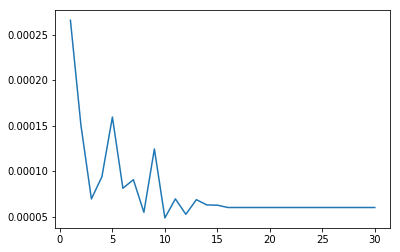

In [3]:
# tree depth from 1 to 30, plot its MSEs
MSEarray = np.zeros(30)
for d in range(1, 31):
    rt = DecisionTreeRegressor(max_depth=d, random_state=0).fit(train_X, train_y)
    pred_y = rt.predict(test_X)
    mse = mean_squared_error(test_y, pred_y)
    MSEarray[d-1] = mse
plt.plot(np.arange(1, 31, 1), MSEarray)
plt.show()

In terms of MSE, we see a little bit of fluctuation. We go with d = 10 as our depth from the above plot. See below for details and comparison.

mse for RT with d = 10 is 0.00007681


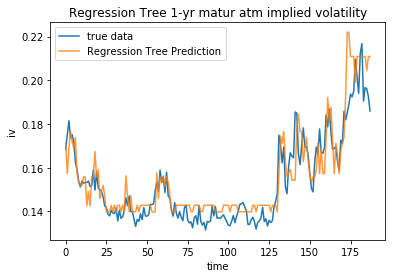

In [24]:
regr_1 = DecisionTreeRegressor(max_depth=10).fit(train_X, train_y)
pred_y1 = regr_1.predict(test_X)
plt.plot(np.array(test_y), label = 'true data')
plt.plot(pred_y1, label = 'Regression Tree Prediction', alpha = 0.8)
plt.xlabel("time")
plt.ylabel("iv")
plt.legend()
plt.title('Regression Tree 1-yr matur atm implied volatility')
plt.savefig('RT.jpg')
mse1 = mean_squared_error(test_y, pred_y1)
print ("mse for RT with d = 10 is %.8f" % mse1)

## 2. Random Forest Regressor

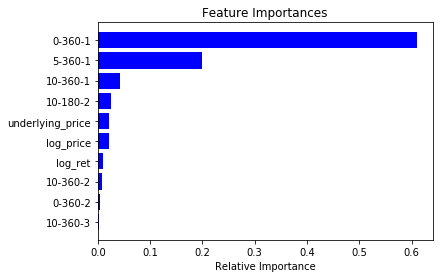

In [37]:
rf1 = RandomForestRegressor(max_depth=10, random_state=0,
      n_estimators=100).fit(train_X, train_y)

importances = rf1.feature_importances_
features = train_X.columns
# top 10 important features
indices = np.argsort(importances)[-10:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center') 
plt.yticks(range(len(indices)), [features[i] for i in indices]) 
plt.xlabel('Relative Importance')
plt.savefig('FI.jpg')

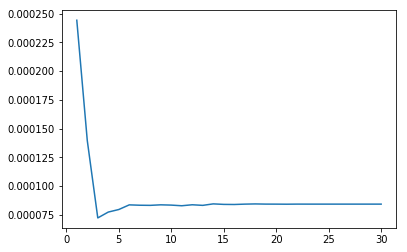

In [44]:
# depth from 1 to 30, plot its MSEs
MSEarray = np.zeros(30)
for d in range(1, 31):
    rt = RandomForestRegressor(max_depth=d, random_state=0,n_estimators=500)\
        .fit(train_X_rf, train_y)
    pred_y = rt.predict(test_X_rf)
    mse = mean_squared_error(test_y, pred_y)
    MSEarray[d-1] = mse
plt.plot(np.arange(1, 31, 1), MSEarray)
plt.show()

mse for RF with d=6 and n=500 is 0.00008553


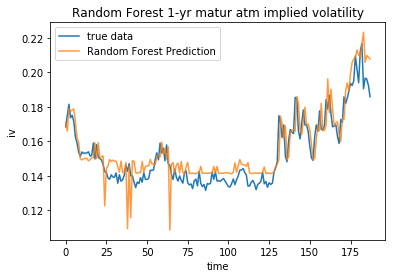

In [47]:
top_number = 3
top_features = [features[indices[-i]] for i in range(1, top_number+1)]
train_X_rf = train_X[top_features]
test_X_rf = test_X[top_features]
rf2 = RandomForestRegressor(max_depth=6,
      n_estimators=500).fit(train_X_rf, train_y)
pred_y_rf = rf2.predict(test_X_rf)
plt.plot(np.array(test_y), label = 'true data')
plt.plot(pred_y_rf, label = 'Random Forest Prediction', alpha = 0.8)
plt.xlabel("time")
plt.ylabel("iv")
plt.legend()
plt.title('Random Forest 1-yr matur atm implied volatility')
plt.savefig('RF.jpg')
mse3 = mean_squared_error(test_y, pred_y_rf)
print ("mse for RF with d=6 and n=500 is %.8f" % mse3)

## 3. GAM

mse for linear GAM is 0.00006237


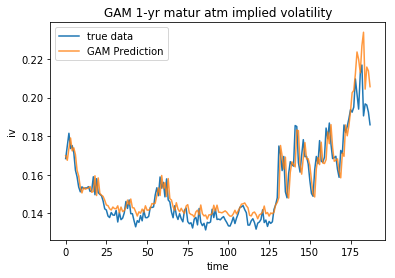

In [48]:
from pygam import LinearGAM

gam1 = LinearGAM().fit(train_X_rf, train_y)
pred_y_gam1 = gam1.predict(test_X_rf)
plt.plot(np.array(test_y), label = 'true data')
plt.plot(pred_y_gam1, label = 'GAM Prediction', alpha = 0.8)
plt.xlabel("time")
plt.ylabel("iv")
plt.legend()
plt.title('GAM 1-yr matur atm implied volatility')
plt.savefig('GAM.jpg')
mse4 = mean_squared_error(test_y, pred_y_gam1)
print ("mse for linear GAM is %.8f" % mse4)

## 4. Linear Regression (on a rolling basis)

mse for linear Regression is 0.00004204


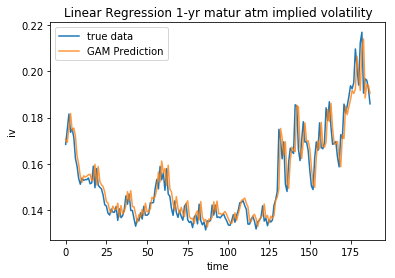

In [57]:
lm1 = LinearRegression().fit(train_X_rf, train_y)
pred_y_lm1 = lm1.predict(test_X_rf)
plt.plot(np.array(test_y), label = 'true data')
plt.plot(pred_y_lm1, label = 'GAM Prediction', alpha = 0.8)
plt.xlabel("time")
plt.ylabel("iv")
plt.legend()
plt.title('Linear Regression 1-yr matur atm implied volatility')
plt.savefig('LR.jpg')
mse8 = mean_squared_error(test_y, pred_y_lm1)
print ("mse for linear Regression is %.8f" % mse8)